# imports

In [196]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gunpowder as gp
import zarr
import math
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import skimage
import networkx
import pathlib
from tifffile import imread, imwrite
import tensorboard
import torch.nn.functional as F
import glob
from abc import ABC, abstractmethod
from tqdm.auto import tqdm 

import scipy
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Model

In [197]:
# model parameters
input_size = (1, 64, 64, 5)
downsample_factors =[(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 2, 1)];
output_classes = 12

# model definition
class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)
#summary(model, input_size)

# define loss function
loss_function = torch.nn.CosineEmbeddingLoss()
#loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# Load model

In [198]:
# path to state file
modelstateP = '/mnt/shared/celltracking/modelstates/aaron/'
stateFile = 'epoch_27'

model.load_state_dict(torch.load(modelstateP+stateFile))
model.eval()

Vgg3D(
  (features): Sequential(
    (0): Conv3d(1, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(12, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), 

# Extract cell- and frame-wise model outputs

In [199]:
# set parameters
volSize = (1,5,64, 64)
zarrdir = '/mnt/shared/celltracking/data/cho/02.zarr'
raw = gp.ArrayKey('raw')

# extract centroids from annotated image stacks
annotationPath = pathlib.Path("/mnt/shared/celltracking/data/cho/")
annotations = np.stack([imread(xi) for xi in sorted((annotationPath / "02_GT/TRA").glob("*.tif"))])  # images
cells = []
for t, frame in enumerate(annotations):
    centers = skimage.measure.regionprops(frame)
    for c in centers:
        cells.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])

# define gp pipeline
pipeline_allCentroids = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: 'raw'},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)})  # meta-information
    + gp.Pad(raw, None))

# constructs gp pipeline

gp.ArraySpec()

# loop over all cell centroids
predictions = []
i=0
for id,t,x,y in cells:
    # determine coordinates
    coord = (t,0,x-(volSize[2]/2),y-(volSize[3]/2))
    request = gp.BatchRequest()
    request[raw] = gp.Roi(coord, volSize)
    
    with gp.build(pipeline_allCentroids):
        batch = pipeline_allCentroids.request_batch(request)
        
    # show the content of the batch
    # print(f"batch returned: {batch}")

    # # plot first slice of volume
    # print(batch[raw].data.shape)
    # plt.imshow(np.flipud(batch[raw].data[0,0,:,:]))

    ## evaluate model for each centroid using gp pipeline
    vol = batch[raw].data
    vol = np.reshape(vol, (1,64, 64, 5))
    vol = np.expand_dims(vol, axis =0)
    vol = torch.from_numpy(vol).to(device).float()
    pred = model(vol)
    pred = pred.detach().cpu().numpy()
    
    # save pred into list with id + position information
    predictions.append([id, t, x, y, pred])
    i += 1
    if i%50==0:
        print(f'done with: {i}/{len(cells)} total')

done with: 50/614 total
done with: 100/614 total
done with: 150/614 total
done with: 200/614 total
done with: 250/614 total
done with: 300/614 total
done with: 350/614 total
done with: 400/614 total
done with: 450/614 total
done with: 500/614 total
done with: 550/614 total
done with: 600/614 total


In [204]:
#predictions # cellid, frame, x,y, embedding vectorp

np.shape(predictions)
#predictions[600:]

(614, 5)

# Linear Assignment Part

# From Paola

# Time Matrices

In [201]:
tracks = np.array(predictions)[:,0:4]# T matrices

<ipython-input-201-9442b887089a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tracks = np.array(predictions)[:,0:4]# T matrices


In [202]:
from scipy.spatial import distance
distances = []
#row corresponds to index of cells in t
rows = [] 
#row corresponds to index of cells in t+1
cols = []

#Loop throug the times frames
for t in range(max(tracks[:,1])):

    #get index
    idxt=np.where(tracks[:,1]==t)[0]
    idxt_next=np.where(tracks[:,1]==t+1)[0]
    t_matrix=np.zeros((len(idxt),len(idxt_next)), dtype=float)

    for ii in range(0, len(idxt)):
        for jj in range(0, len(idxt_next)):
            #coordinate x,y cellN in t
            pt1=[tracks[ii,2], tracks[ii,3]]
            #pt1=tracks[ii,2:]-->embedding
            #coordinate x,y cellN in t next
            pt2=[tracks[jj,2], tracks[jj,3]] 
            #distance from pt1 and pt2
            dist=distance.euclidean(pt1,pt2)
            #dist = np.sqrt(np.sum(np.square(pt1-pt2)))
            #fill matrix with the distances
            
            t_matrix[ii,jj]= dist
            
    #print(t, len(idxt), len(idxt_next))
    distances.append(t_matrix)
    rows.append(idxt)
    cols.append(idxt_next)

# Embedding Vector matrix

In [203]:
from scipy.spatial import distance

predictnp=np.array(predictions)

distances_em = []
#row corresponds to index of cells in t
rows_em = [] 
#row corresponds to index of cells in t+1
cols_em = []

#Loop throug the times frames
for t in range(max(predictnp[:,1])):

    #get index
    idxt=np.where(predictnp[:,1]==t)[0]
    idxt_next=np.where(predictnp[:,1]==t+1)[0]
    t_matrix_emb=np.zeros((len(idxt),len(idxt_next)), dtype=float)

    for ii in range(0, len(idxt)):
        for jj in range(0, len(idxt_next)):
            #coordinate x,y cellN in t
            pt1=predictnp[ii,4][0]
            #pt1=tracks[ii,2:]-->embedding
            #coordinate x,y cellN in t next
            pt2=predictnp[jj,4][0]
            #distance from pt1 and pt2
            dist=distance.euclidean(pt1,pt2)
            #dist = np.sqrt(np.sum(np.square(pt1-pt2)))
            #fill matrix with the distances
            
            t_matrix_emb[ii,jj]= dist
            
    #print(t, len(idxt), len(idxt_next))
    distances_em.append(t_matrix_emb)
    rows_em.append(idxt)
    cols_em.append(idxt_next)

<ipython-input-203-0a95b8899d1f>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictnp=np.array(predictions)


In [221]:
print(np.shape(distances_em[30]))
distances_em[30]

(5, 5)


array([[    0.        ,  7827.51611328, 18449.19335938, 26722.50390625,
         4426.19824219],
       [ 7827.51611328,     0.        , 21411.16796875, 31955.91992188,
         3617.9855957 ],
       [18449.19335938, 21411.16796875,     0.        , 13057.19921875,
        19695.86523438],
       [26722.50390625, 31955.91992188, 13057.19921875,     0.        ,
        29465.11328125],
       [ 4426.19824219,  3617.9855957 , 19695.86523438, 29465.11328125,
            0.        ]])

## Calculate Centroids

In [222]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data

base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")

# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

pts = []
# extract centroids from annotated image stacks

# for img in range(len(centroids))
#     blobs = skimage.measure.regionprops(centroids[img,0,:,:])
#     for blob in blobs:
#         y0, x0 = blob.centroid
#         pts.append((x0, y0))

In [206]:
# # function to convert 'TRA' channel into cell and frame-wise centroid positions
# ## Function to extract trajectories from data

# base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")

# # read parent-child links from file
# links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# # read annotated image stack
# centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

# # extract centroids from annotated image stacks
# centers = skimage.measure.regionprops(centroids[0,0,:,:])
# tracks = []
# centroid_info = []
# cntrs = []
# for t, frame in enumerate(centroids):
#     centers = skimage.measure.regionprops(frame)
#     temp = []
#     for c in centers:
#         tracks.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
#         centroid_info.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
#         temp.append([int(c.centroid[1]), int(c.centroid[2])])
    
#     cntrs.append(temp)
        
# # constructs graph 
# tracks = np.array(tracks)
# graph = networkx.DiGraph()
# for cell_id, t, x, y in tracks:
#     graph.add_node((cell_id,t), x=x, y=y, t=t)
    
# for cell_id, t in graph.nodes():
#     if (cell_id, t+1) in graph.nodes():
#         graph.add_edge((cell_id, t), (cell_id,t+1))

# for child_id, child_from, _, child_parent_id in links:
#     for parent_id, _, parent_to, _ in links:
#         if child_parent_id == parent_id:
#             graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# # extract trajectories from graph set
# tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# # remove tracks with 0 edges
# tracks = [track for track in tracks if len(track.edges)>0]

In [207]:
# plt.figure(figsize=(10,6))
# plt.bar(range(len(cntrs)), [len(xi) for xi in cntrs])
# plt.title(f"Number of detections in each frame")
# plt.xticks(range(len(centers)))
# plt.show()

In [208]:
# G = networkx.complete_graph(tracks)
# networkx.draw_spring(G)

# Euc Distance Function

In [209]:
# Solution Exercise 1.3
def pairwise_euclidian_distance(points0, points1):
    #print("Iterative pairwise euclidian distance")
    dists = []
    for p0 in points0:
        for p1 in points1:
            dists.append(np.sqrt(((p0 - p1)**2).sum()))
            
    dists = np.array(dists).reshape(len(points0), len(points1))
    return dists

## Testing function

In [210]:
# p0 = np.array(cntrs[0]);
# p1 = np.array(cntrs[1]);

# dists = pairwise_euclidian_distance(p0, p1)

In [211]:
tracks

array([[1, 0, 160, 297],
       [4, 0, 273, 208],
       [7, 0, 356, 272],
       ...,
       [20, 91, 99, 296],
       [21, 91, 389, 274],
       [22, 91, 398, 99]], dtype=object)

Optimal frame-by-frame matching (Linear assignment problem or Weighted bipartite matching)
The nearest neighbor algorithm above will not pick the best solution in many cases. For example, it does not consider the local arrangement of a few detections to create links, something which the human visual system is very good at.

We need a better optimization algorithm to minimize the total minimal linking distance between two frames. To use a classic and efficient optimization algorithm, we will represent this linking problem as a bipartite graph. Here is an example:

## Frame by frame linker

In [31]:
class FrameByFrameLinker(ABC):
    """Abstract base class for linking detections by considering pairs of adjacent frames."""
    
    def link(self, detections, images=None):
        """Links detections in t frames.
        
        Args:
        
            detections:
            
                List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                
            images (optional):
            
                List of t numpy arrays of shape (x,y).
        
        Returns:
        
            Linking dictionary:
                "links":
                    
                    Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                    - idgs_from: [from0, from1 , ...])
                    - ids_to: [to0, to1 , ...])
                
                "births": List of ids from frame t that are 
                "deaths": List of ids.
            Ids are one-based, 0 is reserved for background.
        """
        if images is not None:
            assert len(images) == len(detections)
        else:
            images = [None] * len(detections)

        links = []
        for i in tqdm(range(len(images) - 1), desc="Linking"):
            detections0 = detections[i]
            detections1 = detections[i+1]
            self._assert_relabeled(detections0)
            self._assert_relabeled(detections1)
            
            cost_matrix = self.linking_cost_function(detections0, detections1, images[i], images[i+1])
            li = self._link_two_frames(cost_matrix)
            self._assert_links(links=li, time=i, detections0=detections0, detections1=detections1) 
            links.append(li)
            
        return links

    @abstractmethod
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """Calculate features for each detection and extract pairwise costs.
        
        To be overwritten in subclass.
        
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            image0 (optional): image corresponding to detections0
            image1 (optional): image corresponding to detections1
            
        Returns:
        
            m x n cost matrix 
        """
        pass
    
    @abstractmethod
    def _link_two_frames(self, cost_matrix):
        """Link two frames.
        
        To be overwritten in subclass.

        Args:

            cost_matrix: m x n matrix

        Returns:
        
            "links":

                Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                - idgs_from: [from0, from1 , ...])
                - ids_to: [to0, to1 , ...])

            "births": List of ids from frame t that are 
            "deaths": List of ids.
            
            Ids are one-based, 0 is reserved for background.
        """
        pass

    def relabel_detections(self, detections, links):
        """Relabel dense detections according to computed links, births and deaths.
        
        Args:
        
            detections: 
                 
                 List of t numpy arrays of shape (x,y) with contiguous label ids. Background = 0.
                 
            links:
                
                List of t linking dictionaries, each containing:
                    "links": Tuple of lists (ids frame t, ids frame t+1),
                    "births": List of ids,
                    "deaths": List of ids.
                Ids are one-based, 0 is reserved for background.
        """
        detections = detections.copy()
        
        assert len(detections) - 1 == len(links)
        # self._assert_relabeled(detections[0])
        out = [detections[0]]
        n_tracks = out[0].max()
        lookup_tables = [{i: i for i in range(1, out[0].max() + 1)}]

        for i in tqdm(range(len(links)), desc="Recoloring detections"):
            (ids_from, ids_to) = links[i]["links"]
            births = links[i]["births"]
            deaths = links[i+1]["deaths"] if i+1 < len(links) else []
            new_frame = np.zeros_like(detections[i+1])
            # self._assert_relabeled(detections[i+1])
            
            lut = {}
            for _from, _to in zip(ids_from, ids_to):
                # Copy over ID
                #ipdb.set_trace()
                new_frame[detections[i+1] == _to] = lookup_tables[i][_from]
                lut[_to] = lookup_tables[i][_from]

            
            # Start new track for birth tracks
            for b in births:
                if b in deaths:
                    continue
                
                n_tracks += 1
                lut[b] = n_tracks
                new_frame[detections[i+1] == b] = n_tracks
                
            # print(lut)
            lookup_tables.append(lut)
            out.append(new_frame)
                
        return np.stack(out)

    def _assert_links(self, links, time, detections0, detections1):
        if len(links["links"][0]) != len(links["links"][1]):
            raise RuntimeError("Format of links['links'] not correct.")
            
        if sorted([*links["links"][0], *links["deaths"]]) != list(range(1, len(np.unique(detections0)))):
            raise RuntimeError(f"Some detections in frame {time} are not properly assigned as either linked or death.")
            
        if sorted([*links["links"][1], *links["births"]]) != list(range(1, len(np.unique(detections1)))):
            raise RuntimeError(f"Some detections in frame {time + 1} are not properly assigned as either linked or birth.")
            
        for b in links["births"]:
            if b in links["links"][1]:
                raise RuntimeError(f"Links frame {time+1}: Detection {b} marked as birth, but also linked.")
        
        for d in links["deaths"]:
            if d in links["links"][0]:
                raise RuntimeError(f"Links frame {time}: Detection {d} marked as death, but also linked.")
        
        
    def _assert_relabeled(self, x):
        if x.min() < 0:
            raise ValueError("Negative ID in detections.")
        if x.min() == 0:
            n = x.max() + 1
        else:
            n = x.max()
        if n != len(np.unique(x)):
            pass
            #raise ValueError("Detection IDs are not contiguous.")

## Bipartite Matching Linker

In [157]:
class BipartiteMatchingLinker(FrameByFrameLinker):
    """.
    
    Args:
        threshold (float): Maximum euclidian distance for linking.
        drift: tuple of (x,y) drift correction per frame.
        birth_cost_factor (float): Multiply factor with maximum entry in cost matrix.
        death_cost_factor (float): Multiply factor with maximum entry in cost matrix.
    """
    
    def __init__(
        self,
        threshold=np.finfo(float).max,
        drift=(0,0),
        birth_cost_factor=1.05,
        death_cost_factor=1.05,
        *args,
        **kwargs
    ):
        self.threshold = threshold
        self.drift = np.array(drift)
        self.birth_cost_factor = birth_cost_factor
        self.death_cost_factor = death_cost_factor
        
        super().__init__(*args, **kwargs)
        
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances with drift correction.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
#         # regionprops regions are sorted by label
#         regions0 = skimage.measure.regionprops(detections0)
#         #points0 = [np.array(r.centroid) for r in regions0]
#         points0 = []
#         for c in regions0:
#             points0.append([int(c.centroid[1]), int(c.centroid[2])])
        
#         points0 = np.array(points0)
        
#         regions1 = skimage.measure.regionprops(detections1)
#         #points1 = [np.array(r.centroid) for r in regions1]
#         points1 = []
#         for c in regions1:
#             points1.append([int(c.centroid[1]), int(c.centroid[2])])
        
#         points1 = np.array(points1)
        
#         dists = []

#         euc_dists = pairwise_euclidian_distance(points0, points1)
#         euc_dists = np.array(euc_dists).reshape(len(points0), len(points1))

        

        ## incorporate embeddings
        #dists = euc_dists + cos
        
        
        
        return euc_dists
    
    def _link_two_frames(self, cost_matrix):
        """Weighted bipartite matching with square matrix from Jaqaman et al (2008).

        Args:

            cost_matrix: m x n matrix.

        Returns:
            "links":
    
                Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                    - idgs_from: [from0, from1 , ...])
                    - ids_to: [to0, to1 , ...])
                
                "births": List of ids from frame t that are 
                "deaths": List of ids.
                
            Ids are one-based, 0 is reserved for background.
        """
        
        cost_matrix = cost_matrix.copy().astype(float)
        b = self.birth_cost_factor * min(self.threshold, cost_matrix.max())
        d = self.death_cost_factor * min(self.threshold, cost_matrix.max())
        no_link = max(cost_matrix.max(), max(b, d)) * 1e9
        
        cost_matrix[cost_matrix > self.threshold] = no_link
        lower_right = cost_matrix.transpose()

        deaths = np.full(shape=(cost_matrix.shape[0], cost_matrix.shape[0]), fill_value=no_link)
        np.fill_diagonal(deaths, d)
        births = np.full(shape=(cost_matrix.shape[1], cost_matrix.shape[1]), fill_value=no_link)
        np.fill_diagonal(births, b)
        
        square_cost_matrix = np.block([
            [cost_matrix, deaths],
            [births, lower_right],
        ])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(square_cost_matrix)
        
        ids_from = []
        ids_to = []
        births = []
        deaths = []
        for row, col in zip(row_ind, col_ind):
            if row < cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                ids_from.append(row)
                ids_to.append(col)

            if row >= cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                births.append(col)
            if row < cost_matrix.shape[0] and col >= cost_matrix.shape[1]:
                deaths.append(row)

        ids_from = np.array(ids_from)
        ids_to = np.array(ids_to)
        births = np.array(births)
        deaths = np.array(deaths)
                        
        # Account for +1 offset of the dense labels
        ids_from += 1
        ids_to += 1
        births += 1
        deaths += 1
        
        links = {"links": (ids_from, ids_to), "births": births, "deaths": deaths}
        return links

In [158]:
relabeled = np.zeros_like(centroids)
for t in range(centroids.shape[0]):
    relabeled[t, 0] = skimage.segmentation.relabel_sequential(centroids[t, 0])[0]

bm_linker = BipartiteMatchingLinker(threshold=50, drift=(0, 0), birth_cost_factor=1.05, death_cost_factor=1.05)

bm_links = bm_linker.link(relabeled)

Linking: 100%|██████████| 91/91 [00:05<00:00, 17.92it/s]


In [159]:
bm_tracks = bm_linker.relabel_detections(relabeled, bm_links)

Recoloring detections: 100%|██████████| 91/91 [00:00<00:00, 237.34it/s]


# Testing

In [35]:
#bm_links

In [36]:
bm_tracks[0, 0, ...].shape

# for i in range(0, 92, 5):
#     plt.subplot(1,2,1)
#     plt.imshow(bm_tracks[i,0, ...], vmax=np.max(bm_tracks))
    
#     plt.subplot(1,2,2)
#     plt.imshow(centroids[i,0, ...], vmax=np.max(centroids))
#     plt.show()

(443, 512)

In [37]:
#centroid_info
a = np.array([1, 2, 3,4])
b = np.array([10, 20, 30,40])
x = np.where(a > 2)
print(x[0])
print(b[x])

[2 3]
[30 40]


In [38]:
#np.shape(centroid_info[:,0])
#centroid_info
print(np.shape(bm_links))
print(bm_tracks.shape)

(91,)
(92, 5, 443, 512)


In [144]:
test = np.array(centroid_info)

startt = np.min(test[:,1, ...]);
endt = np.max(test[:,1,...]);

cell = 6

inds = np.where(test[:,0] == cell)

times = test[inds, 1]
xposits = test[inds,2]
yposits = test[inds,3]
#for i in range(startt, endt):

# plt.plot(xposits[0], yposits[0])
# plt.xlim([0,512])
# plt.ylim([0,443])
# plt.show()

In [145]:
# x = np.where(bm_tracks[0,0, ...] == 1)
#plt.imshow(bm_tracks[0,0,x[0],x[1]])
# maybe = bm_tracks[np.where(bm_tracks[0,0,...] == 1)]
#blob = skimage.measure.regionprops(bm_tracks[bm_tracks[0,0,...] == 1])
cens = []

# for i in range(92):
#     blobs = skimage.measure.regionprops(bm_tracks[0,0])
#     isCell = False
#     for j in range(len(blobs)):
#         if(blobs[j].label == cell):
#             cens.append(blobs[j].centroid
#             isCell = True
#         else:
#              continue
    
#     if(isCell):
#         continue
#     else:
#         break

cens = []
for i in range(92):
    blobs = skimage.measure.regionprops(bm_tracks[i,0])
    isCell = False
    for j in range(len(blobs)):
        if blobs[j].label == cell:
            cens.append(blobs[j].centroid)
            isCell = True
        continue
        
    if(isCell):
        continue
    else:
        break
        
cens = np.array(cens)
# plt.plot(cens[:,0], cens[:, 1])
# plt.xlim([0,512])
# plt.ylim([0,443])
# plt.show()

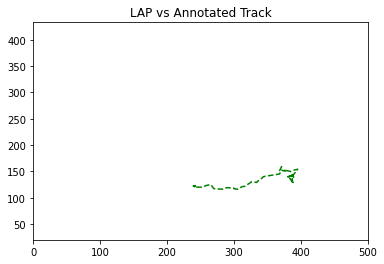

In [146]:
plt.plot(xposits[0], yposits[0], 'r--')
plt.xlim([0,500])
plt.ylim([20,433])
plt.plot(cens[:,0], cens[:, 1], 'g--')
plt.title('LAP vs Annotated Track') 

plt.show()

In [148]:
predictions
#np.shape(predictions)
test = np.array(predictions)
inds = np.where(test[:,0] == 1)

newpred = test[inds]

<ipython-input-148-e19efd1ceb45>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test = np.array(predictions)


In [169]:
# predictions

In [161]:
x1 = test[4,4]
x2 = test[8,4]

print(predictions)

print(len(predictions))
print(len(centroids))
print(scipy.spatial.distance.cosine(x1[0], x2[0]))

[[1, 0, 160, 297, array([[  7770.195 , -18469.22  , -10354.515 ,  17674.717 ,   5795.583 ,
         16273.54  ,   7105.2046,  -4123.329 ,  -5032.6187, -16819.05  ,
          1590.4056,  10218.346 ]], dtype=float32)], [4, 0, 273, 208, array([[  8536.617 , -21871.062 , -11443.676 ,  21673.814 ,   7095.0366,
         19508.102 ,   8196.135 ,  -4920.857 ,  -4863.902 , -20336.3   ,
          1596.6511,  12575.106 ]], dtype=float32)], [7, 0, 356, 272, array([[  5733.0303 , -16769.85   ,  -4270.3696 ,  16714.781  ,
         -2707.229  ,   8084.8296 ,   9418.933  ,   -472.37906,
          4309.2476 , -22026.822  ,   5204.6724 ,  13365.835  ]],
      dtype=float32)], [10, 0, 315, 365, array([[  5691.6265, -11015.014 ,  -2846.4194,  10845.851 ,  -6224.0347,
          1315.5621,   6348.4683,   2967.7405,   5610.4204, -17690.074 ,
          5246.1616,  12394.557 ]], dtype=float32)], [1, 1, 160, 297, array([[  8389.102 , -20552.553 , -11146.214 ,  19665.043 ,   6182.6533,
         17954.957 ,   822

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
    

## With Predictions 

In [32]:
class BipartiteMatchingLinker_WithPred(FrameByFrameLinker):
    """.
    
    Args:
        threshold (float): Maximum euclidian distance for linking.
        drift: tuple of (x,y) drift correction per frame.
        birth_cost_factor (float): Multiply factor with maximum entry in cost matrix.
        death_cost_factor (float): Multiply factor with maximum entry in cost matrix.
    """
    
    def __init__(
        self,
        threshold=np.finfo(float).max,
        drift=(0,0),
        birth_cost_factor=1.05,
        death_cost_factor=1.05,
        *args,
        **kwargs
    ):
        self.threshold = threshold
        self.drift = np.array(drift)
        self.birth_cost_factor = birth_cost_factor
        self.death_cost_factor = death_cost_factor
        
        super().__init__(*args, **kwargs)
        
    def linking_cost_function(self, detections0, detections1, image0=None, image1=None):
        """ Get centroids from detections and compute pairwise euclidian distances with drift correction.
                
        Args:
        
            detections0: image with background 0 and detections 1, ..., m
            detections1: image with backgruond 0 and detections 1, ..., n
            
        Returns:
        
            m x n cost matrix 
        """
        # regionprops regions are sorted by label
        regions0 = skimage.measure.regionprops(detections0)
        #points0 = [np.array(r.centroid) for r in regions0]
        points0 = []
        for c in regions0:
            points0.append([int(c.centroid[1]), int(c.centroid[2])])
        
        points0 = np.array(points0)
        
        regions1 = skimage.measure.regionprops(detections1)
        #points1 = [np.array(r.centroid) for r in regions1]
        points1 = []
        for c in regions1:
            points1.append([int(c.centroid[1]), int(c.centroid[2])])
        
        points1 = np.array(points1)
        
        dists = []

        euc_dists = pairwise_euclidian_distance(points0, points1)
        euc_dists = np.array(euc_dists).reshape(len(points0), len(points1))

        
        ## incorporate imbeddings
        
        
        
        return euc_dists
    
    def _link_two_frames(self, cost_matrix):
        """Weighted bipartite matching with square matrix from Jaqaman et al (2008).

        Args:

            cost_matrix: m x n matrix.

        Returns:
            "links":
    
                Tuple of lists. Links from frame t to frame t+1 of form (from0, to0) are split up into two lists: 
                    - idgs_from: [from0, from1 , ...])
                    - ids_to: [to0, to1 , ...])
                
                "births": List of ids from frame t that are 
                "deaths": List of ids.
                
            Ids are one-based, 0 is reserved for background.
        """
        
        cost_matrix = cost_matrix.copy().astype(float)
        b = self.birth_cost_factor * min(self.threshold, cost_matrix.max())
        d = self.death_cost_factor * min(self.threshold, cost_matrix.max())
        no_link = max(cost_matrix.max(), max(b, d)) * 1e9
        
        cost_matrix[cost_matrix > self.threshold] = no_link
        lower_right = cost_matrix.transpose()

        deaths = np.full(shape=(cost_matrix.shape[0], cost_matrix.shape[0]), fill_value=no_link)
        np.fill_diagonal(deaths, d)
        births = np.full(shape=(cost_matrix.shape[1], cost_matrix.shape[1]), fill_value=no_link)
        np.fill_diagonal(births, b)
        
        square_cost_matrix = np.block([
            [cost_matrix, deaths],
            [births, lower_right],
        ])
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(square_cost_matrix)
        
        ids_from = []
        ids_to = []
        births = []
        deaths = []
        for row, col in zip(row_ind, col_ind):
            if row < cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                ids_from.append(row)
                ids_to.append(col)

            if row >= cost_matrix.shape[0] and col < cost_matrix.shape[1]:
                births.append(col)
            if row < cost_matrix.shape[0] and col >= cost_matrix.shape[1]:
                deaths.append(row)

        ids_from = np.array(ids_from)
        ids_to = np.array(ids_to)
        births = np.array(births)
        deaths = np.array(deaths)
                        
        # Account for +1 offset of the dense labels
        ids_from += 1
        ids_to += 1
        births += 1
        deaths += 1
        
        links = {"links": (ids_from, ids_to), "births": births, "deaths": deaths}
        return links